In [45]:
# CELDA 1 — Imports y configuración
import os
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Rutas (ajusta si tu proyecto está en otra estructura)
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
CLUSTER_DIR = os.path.join(PROCESSED_DIR, "clustering")
PLOTS_DIR = os.path.join(CLUSTER_DIR, "plots")

os.makedirs(CLUSTER_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Resultados de clustering se guardarán en:", CLUSTER_DIR)


Resultados de clustering se guardarán en: d:\Projects\University-Projects\AlphaTech-Analyzer\data\processed\clustering


In [46]:
# CELDA 2 — Cargar agregados (agg_df) desde CSV si no está en memoria
if 'agg_df' not in globals():
    agg_path = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")
    if not os.path.exists(agg_path):
        raise FileNotFoundError(f"No se encontró {agg_path}. Ejecuta antes el pipeline que crea agg_df.")
    agg_df = pd.read_csv(agg_path)

print("agg_df cargado:", agg_df.shape)
agg_df.head()


agg_df cargado: (30, 11)


,Company,Ticker,MeanReturn,Volatility,Beta,AvgVolume,N_months,NormVolume,Cluster,PC1,PC2
0,ASML,ASML,0.015685,0.096761,1.272729,2.083840e+07,83,-1.818646,0,-0.211353,-1.045707
1,Accenture,ACN,0.010715,0.072160,0.989995,4.702290e+07,83,-1.089662,0,-1.024410,-0.260101
2,Adobe,ADBE,0.009672,0.095036,1.187009,6.403960e+07,83,-0.944670,0,-0.443158,-0.511651
3,Alphabet,GOOGL,0.014190,0.072604,0.930717,7.089949e+08,83,0.701873,0,-0.570285,0.788642
4,Amazon,AMZN,0.013438,0.089370,1.245651,1.591051e+09,83,1.262145,0,0.210002,0.761196


In [47]:
# CELDA 3 — Selección y limpieza de variables
# Variables que usaremos para cluster: MeanReturn, Volatility, Beta, AvgVolume
req_cols = ["Company", "MeanReturn", "Volatility", "Beta", "AvgVolume"]
missing = [c for c in req_cols if c not in agg_df.columns]
if missing:
    raise KeyError(f"Faltan columnas en agg_df: {missing}")

agg = agg_df[req_cols].dropna().reset_index(drop=True).copy()

# Asegurar tipos numéricos
for c in ["MeanReturn","Volatility","Beta","AvgVolume"]:
    agg[c] = pd.to_numeric(agg[c], errors="coerce")

agg = agg.dropna(subset=["MeanReturn","Volatility","Beta","AvgVolume"]).reset_index(drop=True)
print("Datos para clustering:", agg.shape)
agg.head()


Datos para clustering: (30, 5)


,Company,MeanReturn,Volatility,Beta,AvgVolume
0,ASML,0.015685,0.096761,1.272729,2.083840e+07
1,Accenture,0.010715,0.072160,0.989995,4.702290e+07
2,Adobe,0.009672,0.095036,1.187009,6.403960e+07
3,Alphabet,0.014190,0.072604,0.930717,7.089949e+08
4,Amazon,0.013438,0.089370,1.245651,1.591051e+09


In [48]:
# CELDA 4 - Normalización del volumen y preparar matriz de features
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import numpy as np

# Normaliza AvgVolume (robusto a outliers)
qt = QuantileTransformer(output_distribution='normal', random_state=0)
agg_df["NormVolume"] = qt.fit_transform(agg_df[["AvgVolume"]].fillna(0))

# Asegurarse que Beta exista (si usaste CELDA 0.5)
# Si no existe Beta, mantén la Beta original que ya tenías en agg_df
features = [
    "MeanReturn",    # Promedio de retornos mensuales (tu MeanReturn)
    "Volatility",    # Volatilidad mensual
    "Beta",          # Beta vs QQQ (siempre que exista)
    "NormVolume"     # Volumen normalizado (creado arriba)
]

# Comprueba nulos en features y decidir estrategia (drop o imputar)
print("Nulos por feature antes de escalar:")
print(agg_df[features].isna().sum())

# Imputación sencilla: medianas (puedes cambiar por otra estrategia)
agg_df[features] = agg_df[features].fillna(agg_df[features].median())

X = agg_df[features].values

# Escalado estándar para KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Guarda X_scaled en el notebook para el clustering
print("Features usadas:", features)


Nulos por feature antes de escalar:
MeanReturn    0
Volatility    0
Beta          0
NormVolume    0
dtype: int64
Features usadas: ['MeanReturn', 'Volatility', 'Beta', 'NormVolume']


📊 k óptimo (Gap Statistic): 2
📊 k óptimo (Davies-Bouldin): 9


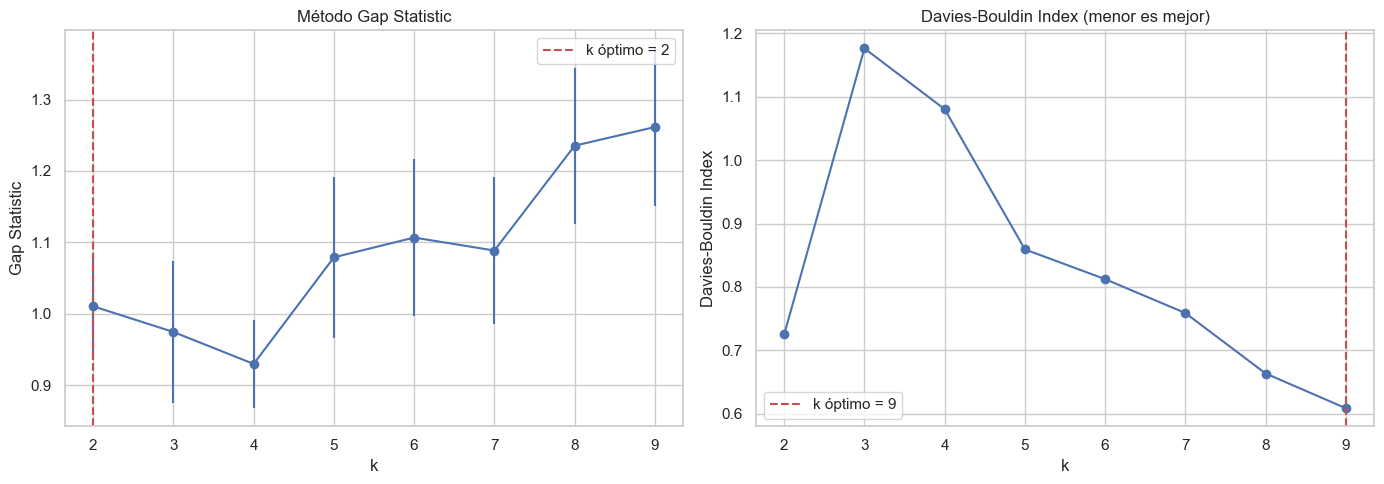

In [49]:
# CELDA 5 – Función Gap Statistic + validación Davies-Bouldin
def gap_statistic(X, k_range, n_refs=10):
    """
    Calcula Gap Statistic para un rango de k.
    
    Parameters:
    -----------
    X : array-like
        Datos normalizados para clustering
    k_range : range
        Rango de valores k a evaluar
    n_refs : int
        Número de datasets de referencia aleatorios
        
    Returns:
    --------
    gaps : list
        Valores de gap statistic para cada k
    sk : list
        Desviaciones estándar para cada k
    k_opt : int
        Valor óptimo de k según Gap Statistic
    """
    gaps = []
    sk = []
    
    for k in k_range:
        # Clustering real
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
        labels = kmeans.fit_predict(X)
        
        # Inertia del clustering real
        W_k = kmeans.inertia_
        
        # Genera datasets de referencia aleatorios
        ref_inertias = []
        for _ in range(n_refs):
            X_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
            kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_ref.fit(X_ref)
            ref_inertias.append(kmeans_ref.inertia_)
        
        # Calcula Gap y su desviación estándar
        E_log_W_k = np.mean(np.log(ref_inertias))
        gap = E_log_W_k - np.log(W_k)
        sd_k = np.std(np.log(ref_inertias))
        s_k = sd_k * np.sqrt(1 + 1/n_refs)
        
        gaps.append(gap)
        sk.append(s_k)
    
    # Encuentra k óptimo: primer k donde gap(k) ≥ gap(k+1) - s(k+1)
    k_opt = k_range[0]
    for i in range(len(gaps)-1):
        if gaps[i] >= gaps[i+1] - sk[i+1]:
            k_opt = k_range[i]
            break
    
    return gaps, sk, k_opt


# Gap Statistic (función definida arriba)
gaps, sk, k_opt_gap = gap_statistic(X_scaled, range(2, 10))

# Davies-Bouldin
from sklearn.metrics import davies_bouldin_score
db_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, labels))

k_opt_db = np.argmin(db_scores) + 2

print(f"📊 k óptimo (Gap Statistic): {k_opt_gap}")
print(f"📊 k óptimo (Davies-Bouldin): {k_opt_db}")

# Plot comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gap Statistic
ax1.errorbar(range(2, 10), gaps, yerr=sk, marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('Gap Statistic')
ax1.set_title('Método Gap Statistic')
ax1.axvline(k_opt_gap, color='r', linestyle='--', label=f'k óptimo = {k_opt_gap}')
ax1.legend()

# Davies-Bouldin
ax2.plot(range(2, 10), db_scores, marker='o')
ax2.set_xlabel('k')
ax2.set_ylabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin Index (menor es mejor)')
ax2.axvline(k_opt_db, color='r', linestyle='--', label=f'k óptimo = {k_opt_db}')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "cluster_selection_professional.png"), dpi=300)
plt.show()

In [50]:
# CELDA 6 — Ajustar KMeans final
k_final = k_opt_gap  # Usa el resultado de Gap Statistic

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=100)
agg_df["Cluster"] = kmeans.fit_predict(X_scaled)

# Validación ANOVA
from scipy.stats import f_oneway
anova_results = {}

for var in features:
    clusters = [agg_df[agg_df["Cluster"] == c][var].values 
                for c in sorted(agg_df["Cluster"].unique())]
    f_stat, p_val = f_oneway(*clusters)
    anova_results[var] = {"F-statistic": f_stat, "p-value": p_val}
    
    print(f"{'✅' if p_val < 0.05 else '⚠️'} {var}: p={p_val:.4f}")

# Guardar validación
pd.DataFrame(anova_results).T.to_csv(
    os.path.join(CLUSTER_DIR, "cluster_validation_anova.csv")
)

# Perfiles de clusters (CORREGIDO a métricas reales)
cluster_profiles = []
for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"] == c]
    cluster_profiles.append({
        "Cluster": c,
        "N": len(sub),
        "Retorno_Mensual_Prom": f"{sub['MeanReturn'].mean():.4f}",
        "Volatilidad_Mensual_Prom": f"{sub['Volatility'].mean():.4f}",
        "Beta_Prom": f"{sub['Beta'].mean():.2f}",
        "Empresas_Top3": ", ".join(
            sub.nlargest(3, "AvgVolume")["Ticker"].values
        )
    })

profiles_df = pd.DataFrame(cluster_profiles)
profiles_df.to_csv(
    os.path.join(CLUSTER_DIR, "cluster_profiles.csv"),
    index=False
)

print("\n📊 PERFILES DE CLUSTERS:")
print(profiles_df.to_string(index=False))


✅ MeanReturn: p=0.0000
✅ Volatility: p=0.0000
✅ Beta: p=0.0000
✅ NormVolume: p=0.0153

📊 PERFILES DE CLUSTERS:
 Cluster  N Retorno_Mensual_Prom Volatilidad_Mensual_Prom Beta_Prom    Empresas_Top3
       0 26               0.0123                   0.0920      0.98 AAPL, AMZN, NFLX
       1  4               0.0353                   0.1904      1.81 NVDA, TSLA, PLTR


In [51]:
# CELDA 6.5 - Métricas de calidad del clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

labels = agg_df["Cluster"].values

# Verifica que haya al menos 2 clusters
if len(set(labels)) > 1:
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)

    print("\n📈 MÉTRICAS DE CALIDAD DEL CLUSTERING")
    print(f"  Silhouette Score: {silhouette:.3f} (rango [-1,1], óptimo ~0.5-0.7)")
    print(f"  Calinski-Harabasz: {calinski:.1f} (mayor = mejor separación)")

    # Interpretación automática
    if silhouette < 0.3:
        print("  ⚠️ ADVERTENCIA: Clusters poco definidos (silhouette bajo)")
    elif silhouette > 0.7:
        print("  ✅ EXCELENTE: Clusters bien definidos")
    else:
        print("  ✓ ACEPTABLE: Estructura de clusters razonable")
else:
    print("No hay suficientes clusters distintos para calcular métricas (necesitas >=2).")



📈 MÉTRICAS DE CALIDAD DEL CLUSTERING
  Silhouette Score: 0.551 (rango [-1,1], óptimo ~0.5-0.7)
  Calinski-Harabasz: 24.6 (mayor = mejor separación)
  ✓ ACEPTABLE: Estructura de clusters razonable


In [52]:
# CELDA 7 — Resumen por cluster
cluster_summary = agg_df.groupby("Cluster")[
    ["MeanReturn","Volatility","Beta","AvgVolume"]
].agg(["mean","std","count"])

cluster_summary.to_csv(os.path.join(CLUSTER_DIR, "cluster_summary_stats.csv"))
print("Resumen por cluster guardado.")
cluster_summary


Resumen por cluster guardado.


MeanReturn                 Volatility                      Beta  \
              mean       std count       mean       std count      mean   
Cluster                                                                   
0         0.012310  0.009266    26   0.092039  0.019162    26  0.979571   
1         0.035337  0.005505     4   0.190358  0.044206     4  1.811993   

                            AvgVolume                      
              std count          mean           std count  
Cluster                                                    
0        0.260919    26  4.329866e+08  5.344310e+08    26  
1        0.344115     4  3.400311e+09  4.316903e+09     4

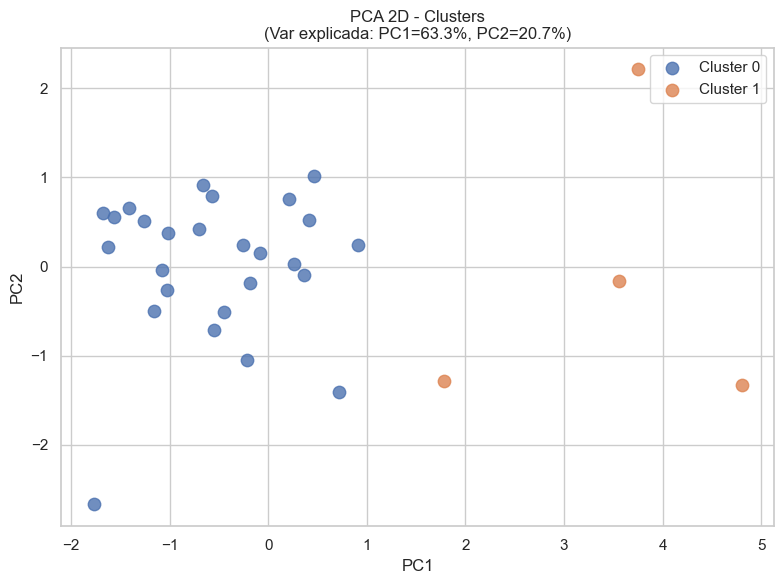

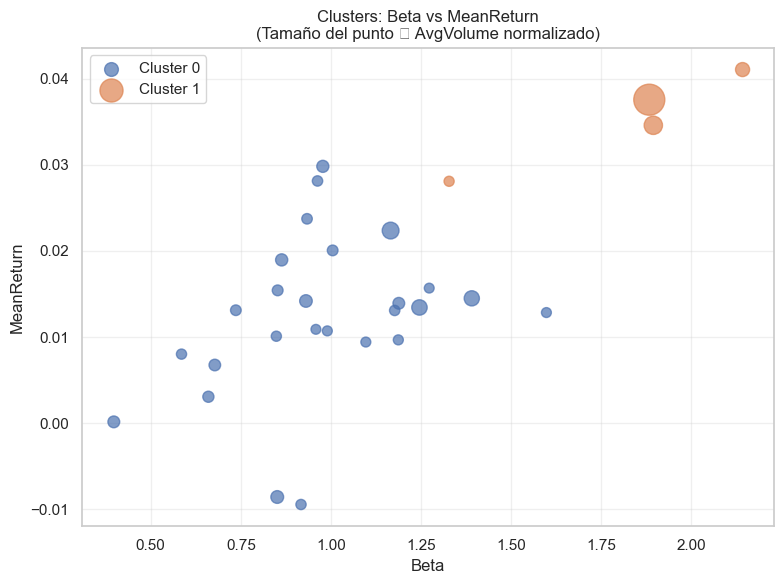

In [53]:
# CELDA 8 – Visualizaciones mejoradas (PCA + scatter Beta vs MeanReturn)

# ===== PCA 2D con varianza explicada =====
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
agg_df["PC1"] = pc[:,0]
agg_df["PC2"] = pc[:,1]

# Obtener varianza explicada por cada componente
var_explained = pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"]==c]
    plt.scatter(sub["PC1"], sub["PC2"], label=f"Cluster {c}", s=80, alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA 2D - Clusters\n(Var explicada: PC1={var_explained[0]:.1%}, PC2={var_explained[1]:.1%})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "pca_clusters.png"), dpi=150)
plt.show()

# ===== Scatter Beta vs MeanReturn con tamaños normalizados =====
plt.figure(figsize=(8,6))

# Normalizar AvgVolume para tamaños de puntos más interpretables
min_vol = agg_df["AvgVolume"].min()
max_vol = agg_df["AvgVolume"].max()

for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"]==c]
    
    # Normaliza tamaños: rango [50, 500] para mejor visualización
    normalized_sizes = ((sub["AvgVolume"] - min_vol) / (max_vol - min_vol)) * 450 + 50
    
    plt.scatter(
        sub["Beta"], 
        sub["MeanReturn"], 
        s=normalized_sizes, 
        alpha=0.7, 
        label=f"Cluster {c}"
    )

plt.xlabel("Beta")
plt.ylabel("MeanReturn")
plt.title("Clusters: Beta vs MeanReturn\n(Tamaño del punto ∝ AvgVolume normalizado)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "beta_vs_meanreturn_clusters.png"), dpi=150)
plt.show()

In [54]:
# CELDA 8.5 - Interpretación económica de clusters
import numpy as np

print("="*80)
print("INTERPRETACIÓN ECONÓMICA DE CLUSTERS")
print("="*80)

for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"] == c].copy()
    n = len(sub)
    if n == 0:
        continue

    beta_mean = sub['Beta'].mean()
    vol_mean = sub['Volatility'].mean()
    ret_mean = sub['MeanReturn'].mean()
    vol_med = sub['AvgVolume'].mean()  # volumen promedio

    print(f"\n📊 CLUSTER {c} ({n} empresas)")
    print(f"  Perfil de Riesgo:")
    print(
        f"    - Beta promedio: {beta_mean:.2f} "
        f"({'Alto' if beta_mean > 1.2 else 'Bajo' if beta_mean < 0.8 else 'Moderado'} riesgo)"
    )
    print(f"    - Volatilidad mensual (promedio): {vol_mean:.4f}")

    print(f"  Perfil de Rentabilidad:")
    print(f"    - Retorno mensual (promedio): {ret_mean:.4f}")

    print(f"  Liquidez:")
    print(f"    - Volumen promedio: ${vol_med/1e9:.2f}B")

    # Empresas representativas por volumen (top 3)
    top3 = ', '.join(
        sub.sort_values('AvgVolume', ascending=False)
           .head(3)['Ticker']
           .fillna('N/A')
           .values
    )
    print(f"  Empresas (top por volumen): {top3}")

    # Recomendación simple (ajustada a métricas mensuales)
    print(f"  Recomendación: ", end="")
    if (ret_mean > 0) and (beta_mean < 1.0):
        print("✅ Perfil conservador – Bajo riesgo / rendimiento estable")
    elif (ret_mean > vol_mean) and (beta_mean > 1.2):
        print("🚀 Perfil agresivo – Alto potencial / alto riesgo")
    else:
        print("⚖️ Perfil balanceado – Riesgo y rentabilidad moderados")


INTERPRETACIÓN ECONÓMICA DE CLUSTERS

📊 CLUSTER 0 (26 empresas)
  Perfil de Riesgo:
    - Beta promedio: 0.98 (Moderado riesgo)
    - Volatilidad mensual (promedio): 0.0920
  Perfil de Rentabilidad:
    - Retorno mensual (promedio): 0.0123
  Liquidez:
    - Volumen promedio: $0.43B
  Empresas (top por volumen): AAPL, AMZN, NFLX
  Recomendación: ✅ Perfil conservador – Bajo riesgo / rendimiento estable

📊 CLUSTER 1 (4 empresas)
  Perfil de Riesgo:
    - Beta promedio: 1.81 (Alto riesgo)
    - Volatilidad mensual (promedio): 0.1904
  Perfil de Rentabilidad:
    - Retorno mensual (promedio): 0.0353
  Liquidez:
    - Volumen promedio: $3.40B
  Empresas (top por volumen): NVDA, TSLA, PLTR
  Recomendación: ⚖️ Perfil balanceado – Riesgo y rentabilidad moderados


In [55]:
# CELDA 9.5 - Detección de outliers dentro de clusters
from scipy.stats import zscore
import numpy as np

print("\n🔍 DETECCIÓN DE OUTLIERS POR CLUSTER (z-score dentro del cluster)")

for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"] == c].copy()
    if len(sub) < 5:
        print(f"\n  Cluster {c}: muy pocas observaciones ({len(sub)}), se omite detección robusta.")
        continue

    # Calcula z-scores dentro del cluster para Beta, MeanReturn y NormVolume
    sub['z_beta'] = np.abs(zscore(sub['Beta']))
    sub['z_return'] = np.abs(zscore(sub['MeanReturn']))
    sub['z_vol'] = np.abs(zscore(sub['NormVolume']))

    # Define outliers (z > 2)
    outliers = sub[
        (sub['z_beta'] > 2) |
        (sub['z_return'] > 2) |
        (sub['z_vol'] > 2)
    ]

    if len(outliers) > 0:
        print(f"\n  Cluster {c} - Outliers detectados ({len(outliers)}):")
        for _, row in outliers.iterrows():
            print(
                f"    - {row['Ticker']}: "
                f"Beta={row['Beta']:.2f}, "
                f"Return_mensual={row['MeanReturn']:.4f}, "
                f"AvgVolume={row['AvgVolume']:.0f}"
            )
    else:
        print(f"\n  Cluster {c}: Sin outliers significativos (z<=2).")



🔍 DETECCIÓN DE OUTLIERS POR CLUSTER (z-score dentro del cluster)

  Cluster 0 - Outliers detectados (5):
    - INTC: Beta=0.85, Return_mensual=-0.0086, AvgVolume=758620795
    - SAP: Beta=0.96, Return_mensual=0.0109, AvgVolume=18683928
    - SNOW: Beta=0.92, Return_mensual=-0.0095, AvgVolume=115646863
    - SPOT: Beta=1.60, Return_mensual=0.0128, AvgVolume=38192011
    - 0700.HK: Beta=0.40, Return_mensual=0.0001, AvgVolume=494464799

  Cluster 1: muy pocas observaciones (4), se omite detección robusta.


In [56]:
# CELDA 9 — Guardar outputs finales
agg_df.to_csv(os.path.join(CLUSTER_DIR, "agg_with_clusters_full.csv"), index=False)

# Guardar summary legible para LaTeX / informe
cluster_summary_reset = cluster_summary.reset_index()
cluster_summary_reset.to_csv(os.path.join(CLUSTER_DIR, "cluster_summary_for_report.csv"), index=False)

# Guardar simple mapping company->cluster
pd.DataFrame({"Company": agg_df["Company"], "Cluster": agg_df["Cluster"]}).to_csv(
    os.path.join(CLUSTER_DIR, "company_cluster_map.csv"), index=False
)

print("✅ Todos los archivos de clustering guardados en:", CLUSTER_DIR)


✅ Todos los archivos de clustering guardados en: d:\Projects\University-Projects\AlphaTech-Analyzer\data\processed\clustering
